In [1]:
%%capture
%load_ext autoreload
%autoreload 2
#Basic Imports
import os,sys
os.chdir("..")

from tqdm import tqdm,trange
import numpy as np
from sklearn.metrics import classification_report
import torch

from datasets.ssl_dataset import SSL_Dataset
from datasets.data_utils import get_data_loader
from utils import get_model_checkpoints
from utils import net_builder
from utils import plot_examples, plot_cmatrix

import pandas as pd

## Initialize parameters

In [2]:
path = "C:\\Users\\meoni\\Documenti\\ESA\\ACT\\Semisupervised\\MSMatch\experiments\\eurosat_runs\\eurosat_rgb\\FixMatch_archefficientnet-b2_batch32_confidence0.95_lr0.03_uratio7_wd0.00075_wu1.0_seed0_numlabels50_optSGD"

In [3]:
checkpoints, args = get_model_checkpoints(path)
args = args[0]

In [4]:
args["batch_size"] = 256
args["data_dir"] = "./data/"
args["use_train_model"] = False
args["load_path"] = checkpoints[0]

## Eval

In [5]:
checkpoint_path = os.path.join(args["load_path"])
checkpoint = torch.load(checkpoint_path)
load_model = (checkpoint["train_model"] if args["use_train_model"] else checkpoint["eval_model"])

_eval_dset = SSL_Dataset(name=args["dataset"], train=False, data_dir=args["data_dir"], seed=args["seed"])
eval_dset = _eval_dset.get_dset()

_net_builder = net_builder(args["net"],None,{})

net = _net_builder(num_classes=_eval_dset.num_classes, in_channels=_eval_dset.num_channels)
net.load_state_dict(load_model)
if torch.cuda.is_available():
    net.cuda()
net.eval()



eval_loader = get_data_loader(eval_dset, args["batch"], num_workers=1)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:21<00:00,  1.92s/it]


Using not pretrained model efficientnet-b2 ...


## Evaluate

In [6]:
label_encoding = _eval_dset.label_encoding
inv_transf = _eval_dset.inv_transform

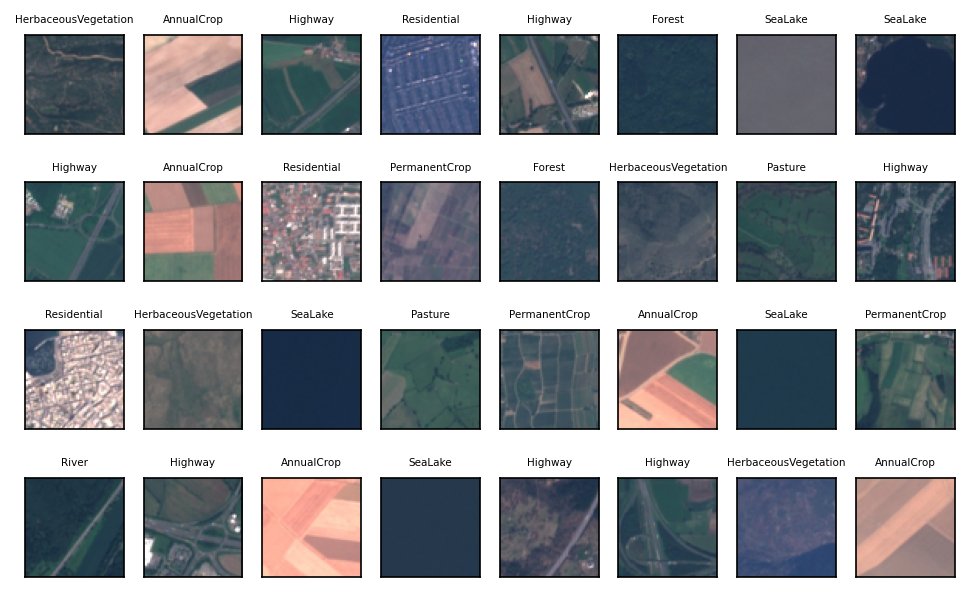

In [7]:
plot_examples(eval_dset.data,eval_dset.targets,label_encoding)

In [8]:
#Assemble a batch
images, labels, preds = [],[],[]
with torch.no_grad():
    for image, target in tqdm(eval_loader):
        image = image.type(torch.FloatTensor).cuda()
        logit = net(image)
        for idx,img in enumerate(image):
            images.append(inv_transf(img.transpose(0,2).cpu().numpy()).transpose(0,2).numpy())
        preds.append(logit.cpu().max(1)[1])
        labels.append(target)
labels = torch.cat(labels).numpy()
preds = torch.cat(preds).numpy()

100%|██████████████████████████████████████████████████████████████████████████████████| 85/85 [00:21<00:00,  4.03it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

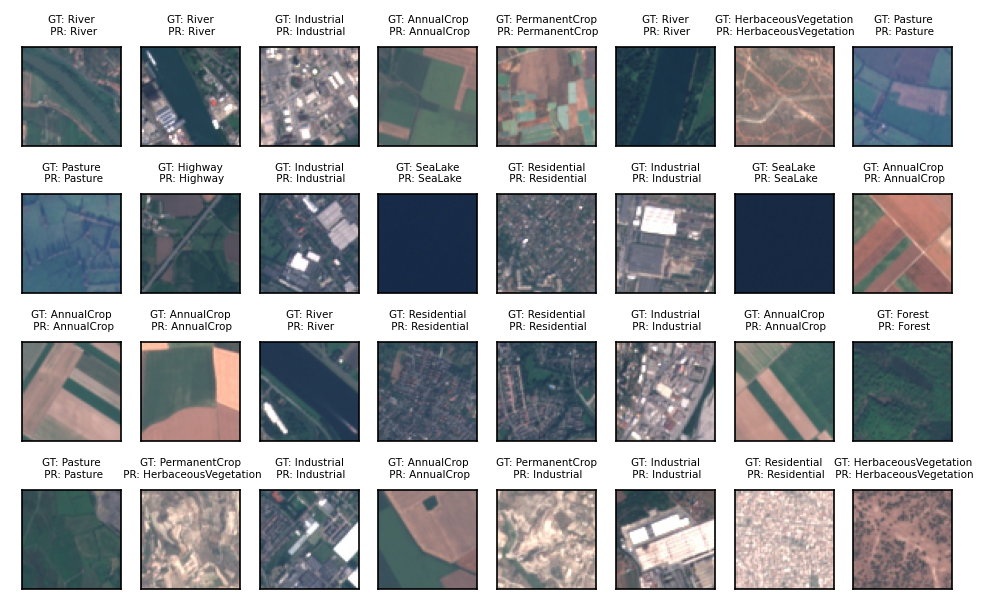

In [9]:
plot_examples(images,labels,label_encoding,preds)

## Evaluate all test data

In [10]:
test_report = classification_report(labels, preds, target_names=label_encoding, output_dict=True)
print(classification_report(labels, preds, target_names=label_encoding))
df = pd.DataFrame(test_report)
df.to_csv("./"+str(args["dataset"])+"_"+str(args["numlabels"]) + "_test_results.csv")

                      precision    recall  f1-score   support

          AnnualCrop       0.95      0.98      0.97       300
              Forest       0.99      0.99      0.99       300
HerbaceousVegetation       0.86      0.97      0.92       300
             Highway       0.96      0.99      0.98       250
          Industrial       0.99      0.96      0.98       250
             Pasture       0.97      0.93      0.95       200
       PermanentCrop       0.95      0.79      0.86       250
         Residential       0.96      1.00      0.98       300
               River       0.97      0.96      0.96       250
             SeaLake       0.99      0.98      0.98       300

            accuracy                           0.96      2700
           macro avg       0.96      0.96      0.96      2700
        weighted avg       0.96      0.96      0.96      2700



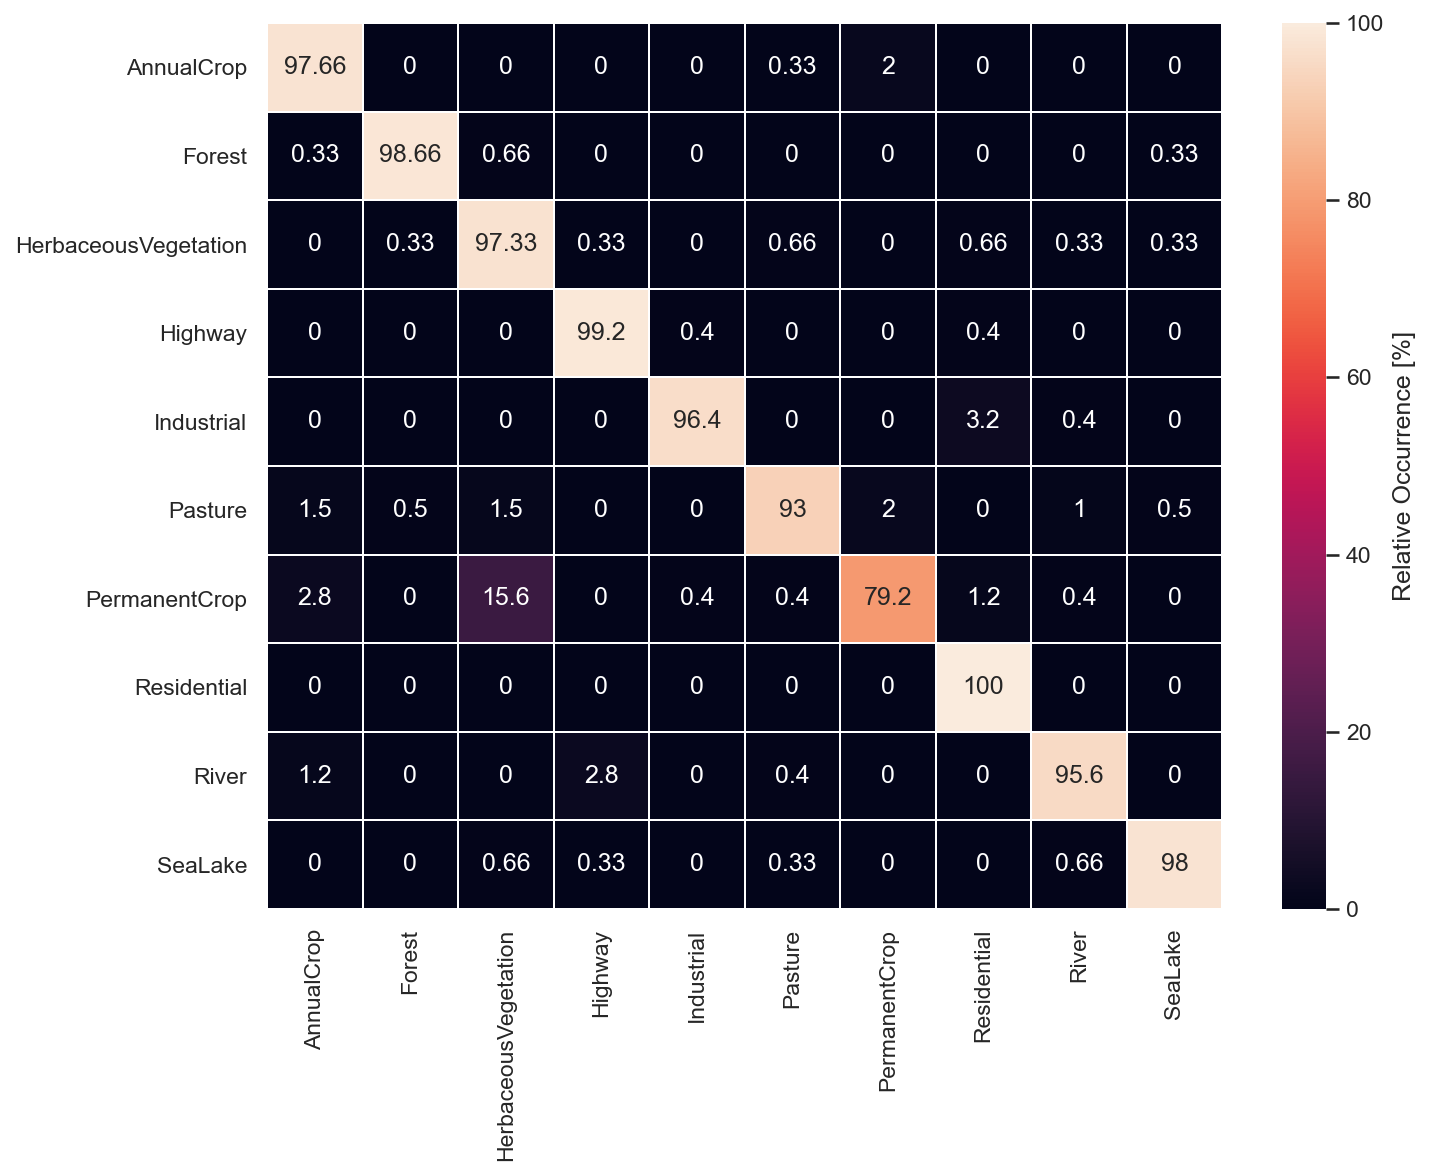

In [43]:
plot_cmatrix(preds,labels,label_encoding, figsize=(10, 8),dpi=150, font_scale=1.0, save_fig_name=str(args["dataset"])+"_"+str(args["numlabels"])+"_cm.png")